In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
import sys
from enum import Enum
from math import sqrt
import cv2
import numpy as np

class ConvolutionType(Enum):
    MeanFilter = 1
    Sobel_X = 2
    Sobel_Y = 3
    Laplace = 4

class UnsharpService:
    def __init__(self, threshold):
        self.__threshold = threshold

        self.__mean_mask = [1, 1, 1,
                            1, 1, 1,
                            1, 1, 1]

        self.__sobel_x_mask = [-1, 0, 1,
                               -2, 0, 2,
                               -1, 0, 1]

        self.__sobel_y_mask = [-1, -2, -1,
                               0, 0, 0,
                               1, 2, 1]

        self.__laplace_mask = [-1, -1, -1,
                               -1, 8, -1,
                               -1, -1, -1]

    def mean_filter(self, img):
        rows = img.shape[0]
        cols = img.shape[1]
        mean_img = np.zeros((rows, cols), dtype=img.dtype)
        self.__convolution(img, mean_img, self.__mean_mask, ConvolutionType.MeanFilter)
        return mean_img

    def __sobel_y(self, src, out):
        self.__convolution(src, out, self.__sobel_y_mask, ConvolutionType.Sobel_Y)

    def __sobel_x(self, src, out):
        self.__convolution(src, out, self.__sobel_x_mask, ConvolutionType.Sobel_X)

    def get_diff_1(self, img):
        rows = img.shape[0]
        cols = img.shape[1]
        sobel_y_img = np.zeros((rows, cols), dtype=img.dtype)
        sobel_x_img = np.zeros((rows, cols), dtype=img.dtype)
        diff_1_img = np.zeros((rows, cols), dtype=img.dtype)

        self.__sobel_y(img, sobel_y_img)  # sobel y
        self.__sobel_x(img, sobel_x_img)  # sobel x

        for i in range(1, rows - 1):
            for j in range(1, cols - 1):
                sobel = int(sobel_x_img[i, j]) + int(sobel_y_img[i, j])
                diff_1_img[i, j] = self.__chk_val(sobel)

        # 對一階微分結果進行均值濾波
        mean_diff_1_img = self.mean_filter(diff_1_img) # unsharp mask

        return mean_diff_1_img

    def get_diff_2(self, img):
        rows = img.shape[0]
        cols = img.shape[1]

        diff_2_img = np.zeros((rows, cols), dtype=img.dtype)
        self.__laplace(img, diff_2_img)

        return diff_2_img

    def __laplace(self, src, out):
        self.__convolution(src, out, self.__laplace_mask, ConvolutionType.Laplace)

    def __convolution(self, src, out, mask, conv_type):
        rows = out.shape[0]
        cols = out.shape[1]

        for i in range(1, rows - 1):
            for j in range(1, cols - 1):
                conv = mask[0] * src[i - 1, j - 1] + \
                       mask[1] * src[i - 1, j] + \
                       mask[2] * src[i - 1, j + 1] + \
                       mask[3] * src[i, j - 1] + \
                       mask[4] * src[i, j] + \
                       mask[5] * src[i, j + 1] + \
                       mask[6] * src[i + 1, j - 1] + \
                       mask[7] * src[i + 1, j] + \
                       mask[8] * src[i + 1, j + 1]

                if conv_type == ConvolutionType.MeanFilter:
                    conv = conv / 9
                    conv = 255 if conv > self.__threshold else 0
                elif conv_type == ConvolutionType.Sobel_X or conv_type == ConvolutionType.Sobel_Y:
                    conv = abs(conv)

                out[i, j] = self.__chk_val(conv)

    @staticmethod
    def __chk_val(v):
        if v > 255:
            return 255
        if v < 0:
            return 0
        return v

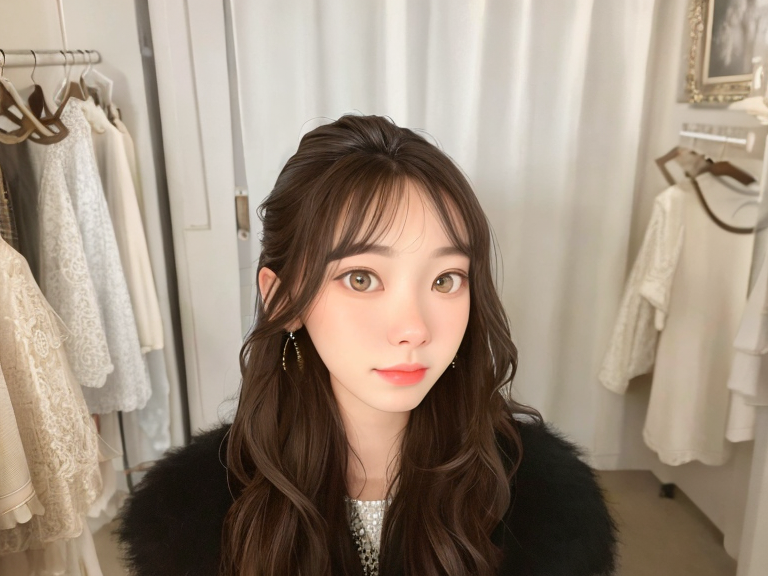

In [ ]:
img_path = 'IMG_1.PNG'
threshold = 128
input_img = cv2.imread(img_path)
cv2_imshow(input_img)

gray_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)

service = UnsharpService(threshold=threshold)
diff_1_img = service.get_diff_1(gray_img)
diff_2_img = service.get_diff_2(gray_img)

# enha_img = service.enhancement(input_img, diff_2_img, mean_img)

# cv2_imshow(gray_img)
# cv2_imshow(diff_1_img)  # sobel
# cv2_imshow(diff_2_img)  # laplac
# # cv2_imshow(enha_img)

# # 隨意Key一鍵結束程式
# cv2.waitKey(0)
# cv2.destroyAllWindows()

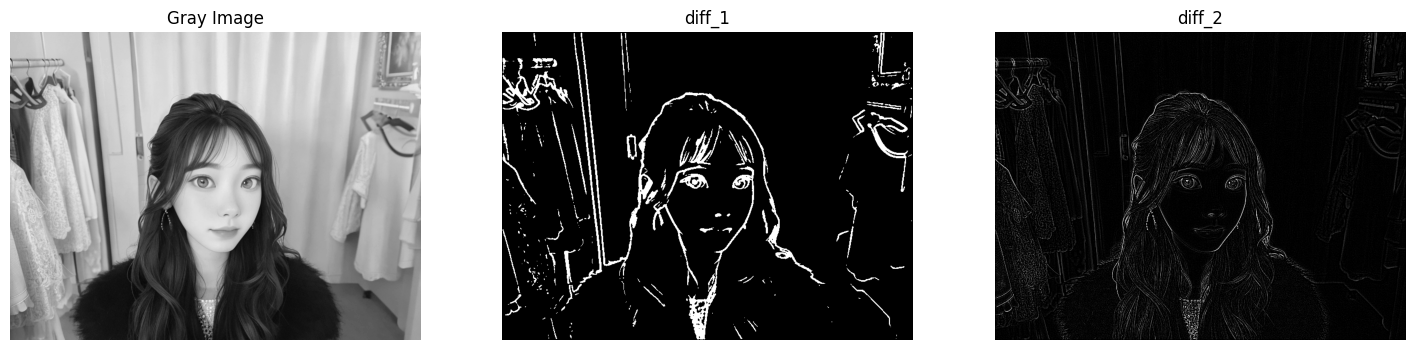

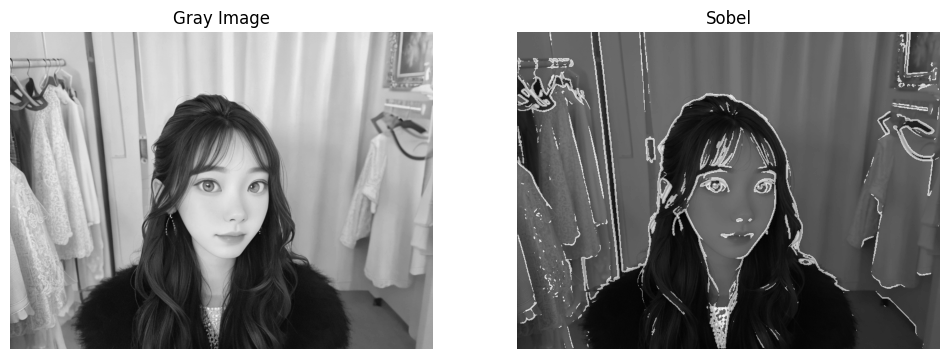

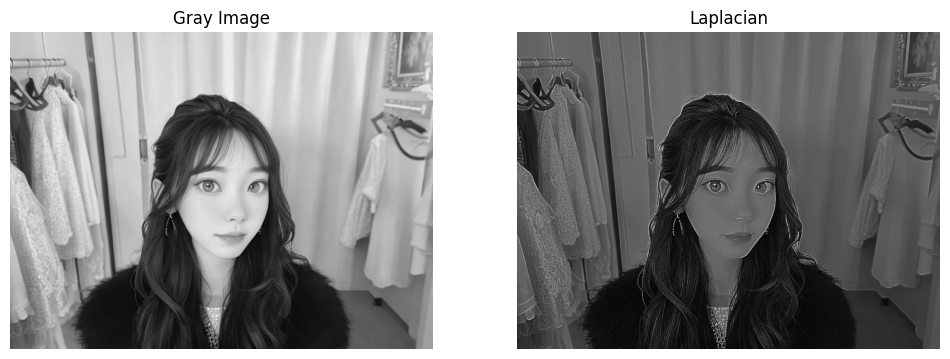

In [ ]:
import matplotlib.pyplot as plt

# 設定畫布大小
plt.figure(figsize=(18, 6))

# 顯示灰度圖像
plt.subplot(1, 3, 1)
plt.imshow(gray_img, cmap='gray')
plt.title('Gray Image')
plt.axis('off')  # 隱藏坐標軸

# 顯示一階微分結果
plt.subplot(1, 3, 2)
plt.imshow(diff_1_img, cmap='gray')
plt.title('diff_1')
plt.axis('off')  # 隱藏坐標軸

# 顯示二階微分結果
plt.subplot(1, 3, 3)
plt.imshow(diff_2_img, cmap='gray')
plt.title('diff_2')
plt.axis('off')  # 隱藏坐標軸
plt.show()

# 確保兩張圖片的尺寸相同
if gray_img.shape != diff_1_img.shape:
    print(f"{gray_img.shape}/{diff_1_img.shape}")
    raise ValueError("The images1 must have the same size to be blended.")
if gray_img.shape != diff_2_img.shape:
    print(f"{gray_img.shape}/{ diff_2_img.shape}")
    raise ValueError("The images2 must have the same size to be blended.")

# 將兩張圖片疊加
alpha = 0.5  # 第一張圖片的權重
beta = 0.5   # 第二張圖片的權重
blended_img1 = cv2.addWeighted(gray_img, alpha, diff_1_img, beta, 0)
blended_img2 = cv2.addWeighted(gray_img, alpha, diff_2_img, beta, 0)

plt.figure(figsize=(12, 6))
# 顯示灰度圖像
plt.subplot(1, 2, 1)
plt.imshow(gray_img, cmap='gray')
plt.title('Gray Image')
plt.axis('off')  # 隱藏坐標軸

# 顯示 Sobel 邊緣檢測結果
plt.subplot(1, 2, 2)
plt.imshow(blended_img1, cmap='gray')
plt.title('Sobel')
plt.axis('off')  # 隱藏坐標軸
plt.show()

plt.figure(figsize=(12, 6))
# 顯示灰度圖像
plt.subplot(1, 2, 1)
plt.imshow(gray_img, cmap='gray')
plt.title('Gray Image')
plt.axis('off')  # 隱藏坐標軸

# 顯示 Sobel 邊緣檢測結果
plt.subplot(1, 2, 2)
plt.imshow(blended_img2, cmap='gray')
plt.title('Laplacian')
plt.axis('off')  # 隱藏坐標軸
plt.show()

In [ ]:
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')  # 避免除以零的情況，如果兩張圖片完全相同
    pixel_max = 255.0
    psnr = 20 * np.log10(pixel_max / np.sqrt(mse))
    return psnr

# 計算 PSNR
psnr_value1 = calculate_psnr(gray_img, blended_img1)
print(f"PSNR Value between gray_img and blended_img1 is {psnr_value1} dB")
psnr_value2 = calculate_psnr(gray_img, blended_img2)
print(f"PSNR Value between gray_img and blended_img2 is {psnr_value2} dB")
print(f"PSNR1 - PSNR2 = {psnr_value1-psnr_value2}")

PSNR Value between gray_img and blended_img1 is 27.142685263973796 dB
PSNR Value between gray_img and blended_img2 is 27.367793614735664 dB
PSNR1 - PSNR2 = -0.22510835076186808
